In [1]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from torchvision.models import resnet34, ResNet34_Weights
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, Grayscale, GaussianBlur

from zennit.attribution import Gradient, SmoothGrad
from zennit.torchvision import ResNetCanonizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat, EpsilonAlpha2Beta1Flat, EpsilonAlpha2Beta1, EpsilonPlus
from zennit.image import imgify, imsave

from PIL import Image

from tempo.models import NewTempoLinear
from tempo.data.datasets import finetune_dataset2

In [2]:
MODEL_NAME = "asl_big_e10_p30_run5.pth"

In [3]:
# load models
weights_tp = torch.load(f'../model_zoo/{MODEL_NAME}')
model_tp = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_tp.load_state_dict(weights_tp)
model_tp.requires_grad = True
_ = model_tp.eval()

weights_bl = torch.load('../model_zoo/baseline.pth')
model_bl = NewTempoLinear(out_features=24, weights=None,freeze_backbone=True)
model_bl.load_state_dict(weights_bl)
model_bl.requires_grad = True
_ = model_bl.eval()

In [4]:
def get_relevance(model, data, num_classes):

    with torch.no_grad():
        pred = torch.argmax(model(data).flatten()).item()

    canonizer = ResNetCanonizer()

    # create a composite, specifying the canonizers
    composite = EpsilonPlusFlat(canonizers=[canonizer])

    # choose a target class for the attribution (label 437 is lighthouse)
    target = torch.eye(num_classes)[[pred]]

    # create the attributor, specifying model and composite
    with Gradient(model=model, composite=composite) as attributor:
        # compute the model output and attribution
        output, attribution = attributor(data, target)

    relevance = attribution.sum(1)

    return pred, relevance

In [5]:
# define the base image transform
transform_img = Compose([
    Resize(128),
    # CenterCrop(224),
])
# define the normalization transform
transform_norm = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# define the full tensor transform
transform = Compose([
    transform_img,
    ToTensor(),
    transform_norm,
])

# load the image
image = Image.open('IMG_0246.png')

# transform the PIL image and insert a batch-dimension
data = transform(image)[None]

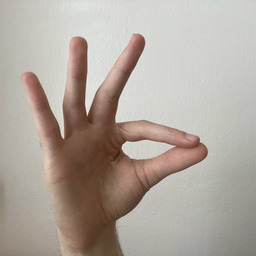

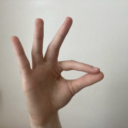

In [6]:
# display the original image
display(image)
# display the resized and cropped image
display(transform_img(image))

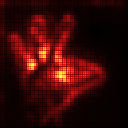

In [7]:
pred, relevance = get_relevance(model_tp, data, num_classes=24)

# create an image of the visualize attribution the relevance is only
# positive, so we use symmetric=False and an unsigned color-map
img = imgify(relevance, symmetric=False, cmap='hot')

# show the image
display(img)

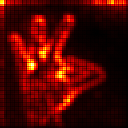

In [8]:
pred, relevance = get_relevance(model_bl, data, num_classes=24)

# create an image of the visualize attribution the relevance is only
# positive, so we use symmetric=False and an unsigned color-map
img = imgify(relevance, symmetric=False, cmap='hot')

# show the image
display(img)

In [9]:
relevance.sum()

tensor(0.4107)

In [10]:
# load the image
mask = Image.open('gtFine/Test/IMG_0246_gtFine_color.png')


In [11]:
mask_tensor = ToTensor()(mask) / 0.6

In [12]:
mask_tensor.size()

torch.Size([3, 256, 256])

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, Grayscale, InterpolationMode

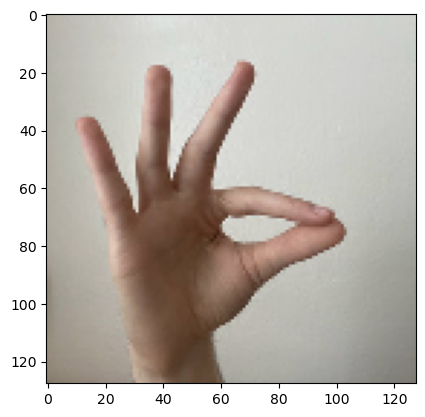

In [14]:
transform = Compose([
    Resize(128, interpolation=InterpolationMode.NEAREST),
    ToTensor(),
])

# load the image
image = transform(Image.open('IMG_0246.png'))
plt.imshow(image.permute(1,2,0))

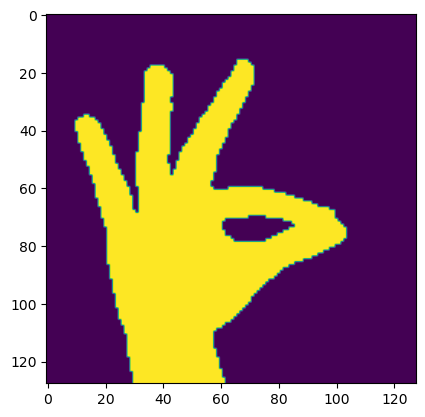

In [15]:
transform_mask = Compose([
    Grayscale(),
    Resize(128, InterpolationMode.NEAREST),
    ToTensor(),
])

# laod the mask
mask = transform_mask(Image.open('gtFine/Test/IMG_0246_gtFine_color.png'))
mask = (mask > 0).to(float)
plt.imshow(mask.permute(1,2,0))

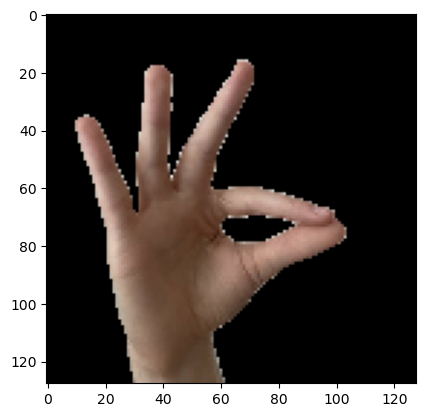

In [16]:
cutout = image * mask
plt.imshow(cutout.permute(1,2,0))

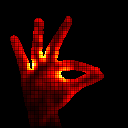

tensor(0.5890, dtype=torch.float64)


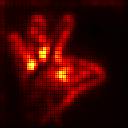

In [17]:
# compute relevances
data = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)[None]
pred, relevance = get_relevance(model_tp, data, num_classes=24)

relevance_in = relevance * mask

heatmap = imgify(relevance_in, symmetric=False, cmap='hot')
display(heatmap)
print(relevance_in.sum() / relevance.sum())
display(imgify(relevance, symmetric=False, cmap='hot'))

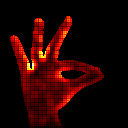

tensor(0.5404, dtype=torch.float64)


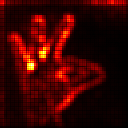

In [18]:
# compute relevances
data = Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)[None]
pred, relevance = get_relevance(model_bl, data, num_classes=24)

relevance_in = relevance * mask

heatmap = imgify(relevance_in, symmetric=False, cmap='hot')
display(heatmap)
print(relevance_in.sum() / relevance.sum())
display(imgify(relevance, symmetric=False, cmap='hot'))

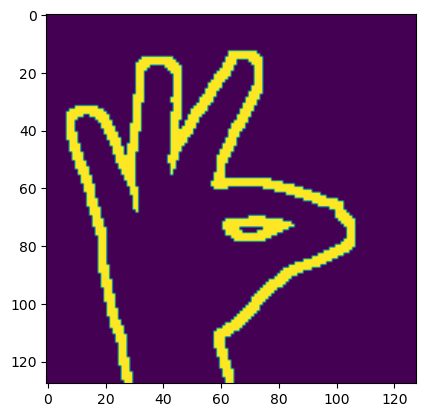

In [19]:
transform_mask_blur = Compose([
    Grayscale(),
    Resize(128, InterpolationMode.NEAREST),
    ToTensor(),
])

# widen the mask
mask_blur = transform_mask_blur(Image.open('gtFine/Test/IMG_0246_gtFine_color.png'))
mask_blur = GaussianBlur(kernel_size=3)(mask_blur)
mask_blur = (mask_blur > 0).to(float)
mask_blur = GaussianBlur(kernel_size=3)(mask_blur)
mask_blur = (mask_blur > 0).to(float)
mask_blur = GaussianBlur(kernel_size=3)(mask_blur)
mask_blur = (mask_blur > 0).to(float)

negative = mask_blur - mask

plt.imshow(negative.permute(1,2,0))

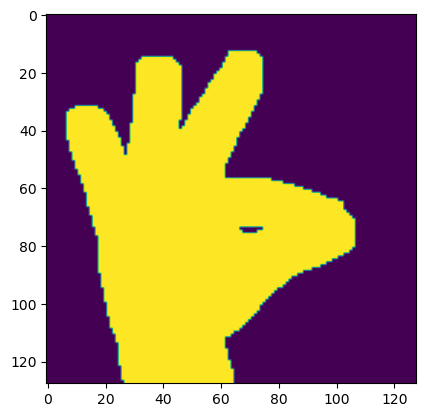

In [20]:
plt.imshow(mask_blur.permute(1,2,0))

In [21]:
def rof(heatmap: torch.FloatTensor, mask: torch.FloatTensor) -> int:
    heat_total = heatmap.sum().item()
    heat_inside = (heatmap * mask).sum().item()
    
    return heat_inside / heat_total

In [22]:
rof(relevance, mask_blur)

0.7465388459254219